# Use Natural Policy Gradient to Play Acrobot-v1

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

14:00:56 [INFO] env: <AcrobotEnv<Acrobot-v1>>
14:00:56 [INFO] action_space: Discrete(3)
14:00:56 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
14:00:56 [INFO] reward_range: (-inf, inf)
14:00:56 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
14:00:56 [INFO] _max_episode_steps: 500
14:00:56 [INFO] _elapsed_steps: None
14:00:56 [INFO] id: Acrobot-v1
14:00:56 [INFO] entry_point: gym.envs.classic_control:AcrobotEnv
14:00:56 [INFO] reward_threshold: -100.0
14:00:56 [INFO] nondeterministic: False
14:00:56 [INFO] max_episode_steps: 500
14:00:56 [INFO] _kwargs: {}
14:00:56 [INFO] _env_name: Acrobot


In [3]:
class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)

    def store(self, df):
        if self.memory.empty:
            self.memory = df[self.fields]
        else:
            self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)

    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.fields)

In [4]:
def conjugate_gradient(f, b, iter_count=10, epsilon=1e-12, tol=1e-6):
    x = b * 0.
    r = tf.identity(b)
    p = tf.identity(b)
    rho = tf.reduce_sum(r * r)
    for i in range(iter_count):
        z = f(p)
        alpha = rho / (tf.reduce_sum(p * z) + epsilon)
        x += alpha * p
        r -= alpha * z
        rho_new = tf.reduce_sum(r * r)
        p = r + (rho_new / rho) * p
        rho = rho_new
        if rho < tol:
            break
    return x, f(x)

In [5]:
class NPGAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = PPOReplayer()
        self.trajectory = []

        self.max_kl = 0.0005
        self.actor_net = self.build_net(hidden_sizes=[100,],
                output_size=self.action_n, output_activation=nn.softmax)
        self.critic_net = self.build_net(hidden_sizes=[100,],
                learning_rate=0.002)

    def build_net(self, input_size=None, hidden_sizes=None, output_size=1,
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(layers.Dense(units=hidden_size,
                    activation=activation))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, terminated):
        probs = self.actor_net.predict(observation[np.newaxis], verbose=0)[0]
        action = np.random.choice(self.action_n, p=probs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, terminated, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5):  # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer()
                        # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'terminated', 'action'], dtype=object)
        states = np.stack(df['state'])
        df['v'] = self.critic_net.predict(states, verbose=0)
        pis = self.actor_net.predict(states, verbose=0)
        df['prob'] = [pi[action] for pi, action in zip(pis, df['action'])]
        df['next_v'] = df['v'].shift(-1).fillna(0.)
        df['u'] = df['reward'] + self.gamma * df['next_v']
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                df['delta'][::-1])[::-1]
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        action_tensor = tf.convert_to_tensor(actions, dtype=tf.int32)
        old_pi_tensor = tf.convert_to_tensor(old_pis, dtype=tf.float32)
        advantage_tensor = tf.convert_to_tensor(advantages, dtype=tf.float32)

        # update actor
        # ... calculate first order gradient of KL divergence
        with tf.GradientTape() as tape:
            all_pi_tensor = self.actor_net(state_tensor)
            pi_tensor = tf.gather(all_pi_tensor, action_tensor, batch_dims=1)
            surrogate_tensor = (pi_tensor / old_pi_tensor) * advantage_tensor
        actor_grads = tape.gradient(surrogate_tensor, self.actor_net.variables)
        loss_grad = tf.concat([tf.reshape(grad, (-1,)) for grad in actor_grads],
                axis=0)

        # ... calculate conjugate gradient: Fx = g
        def f(x):  # calculate Fx
            with tf.GradientTape() as tape2:  # tape for 2nd-order gradient
                with tf.GradientTape() as tape1:  # tape for 1st-order gradient
                    prob_tensor = self.actor_net(state_tensor)
                    prob_old_tensor = tf.stop_gradient(prob_tensor)
                    kld_tensor = tf.reduce_sum(prob_old_tensor * (tf.math.log(
                            prob_old_tensor) - tf.math.log(prob_tensor)), axis=1)
                    kld_loss_tensor = tf.reduce_mean(kld_tensor)
                grads = tape1.gradient(kld_loss_tensor, self.actor_net.variables)
                flatten_grad_tensor = tf.concat(
                        [tf.reshape(grad, (-1,)) for grad in grads], axis=-1)
                grad_matmul_x = tf.tensordot(flatten_grad_tensor, x,
                        axes=[[-1], [-1]])
            grad_grads = tape2.gradient(grad_matmul_x, self.actor_net.variables)
            flatten_grad_grad = tf.stop_gradient(tf.concat(
                    [tf.reshape(grad_grad, (-1,)) for grad_grad in grad_grads],
                    axis=-1))
            fx = flatten_grad_grad + x * 1e-2
            return fx
        x, fx = conjugate_gradient(f, loss_grad)

        # ... calculate natural gradient
        natural_gradient_tensor = tf.sqrt(2 * self.max_kl /
                tf.reduce_sum(fx * x)) * x
        # ....... refactor the flatten gradient into un-flatten version
        flatten_natural_gradient = natural_gradient_tensor.numpy()
        weights = []
        begin = 0
        for weight in self.actor_net.get_weights():
            end = begin + weight.size
            weight += flatten_natural_gradient[begin:end].reshape(weight.shape)
            weights.append(weight)
            begin = end
        self.actor_net.set_weights(weights)

        # update critic
        self.critic_net.fit(states, returns, verbose=0)


agent = NPGAgent(env)

14:00:57 [INFO] ==== train ====
14:01:37 [INFO] NumExpr defaulting to 8 threads.
14:01:37 [INFO] train episode 0: reward = -500.00, steps = 500
14:02:18 [INFO] train episode 1: reward = -500.00, steps = 500
14:02:57 [INFO] train episode 2: reward = -500.00, steps = 500
14:03:37 [INFO] train episode 3: reward = -500.00, steps = 500
14:04:10 [INFO] train episode 4: reward = -422.00, steps = 423
14:04:40 [INFO] train episode 5: reward = -388.00, steps = 389
14:05:14 [INFO] train episode 6: reward = -411.00, steps = 412
14:05:47 [INFO] train episode 7: reward = -427.00, steps = 428
14:06:28 [INFO] train episode 8: reward = -500.00, steps = 500
14:07:12 [INFO] train episode 9: reward = -500.00, steps = 500
14:07:34 [INFO] train episode 10: reward = -279.00, steps = 280
14:08:13 [INFO] train episode 11: reward = -500.00, steps = 500
14:08:33 [INFO] train episode 12: reward = -237.00, steps = 238
14:08:55 [INFO] train episode 13: reward = -273.00, steps = 274
14:09:17 [INFO] train episode 14:

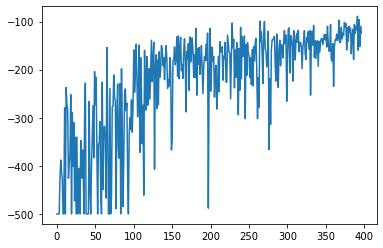

In [6]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation, _ = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, terminated)
        if render:
            env.render()
        if terminated or truncated:
            break
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode,
            mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [7]:
env.close()